In [1]:
# Import the Libraries
from tensorflow.keras.utils import get_file
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tarfile
from glob import glob
import os,re,string

In [2]:
# defining a function to plot epoch vs loss
def loss_plt(history):
  plt.plot(history.history['val_loss'],label="val loss")
  plt.plot(history.history['loss'],label="train loss")
  plt.xlabel('no of epoch')
  plt.ylabel('loss')

  plt.legend()
  plt.show()

# defining a function to plot epoch vs accuracy
def acc_plt(history):
  plt.plot(history.history['val_acc'],label="val accuracy")
  plt.plot(history.history['acc'],label="train accuracy")
  plt.xlabel('no of epoch')
  plt.ylabel('accuracy')

  plt.legend()
  plt.show()

In [3]:
# downloading the data from the given link
data_dir = get_file('aclImdb_v1.tar.gz', 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', cache_subdir = "datasets",hash_algorithm = "auto", extract = True, archive_format = "auto")
my_tar = tarfile.open(data_dir)
# extracting the data from the .tar file and specifying the folder 
my_tar.extractall('./data/')
my_tar.close()

PermissionError: [Errno 13] Permission denied: '.\\data\\aclImdb\\train\\unsup\\11453_0.txt'

In [4]:
# Extracting training and test data from the specified path
path_loc ='./data/aclImdb/'
review = ['neg','pos']

def loading_texts_labels(path, folders):
    texts,labels = [],[]
    for index,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(index)
    
    return texts, np.array(labels).astype(np.int64)

X_train,Y_train = loading_texts_labels(f'{path_loc}train',review)
X_test,Y_test = loading_texts_labels(f'{path_loc}test',review)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 194: character maps to <undefined>

In [ ]:
# Preprocessing the reviews
def rev_preprocess(reviews):
    tokens = re.compile("[.;:!#\'?,\"()\[\]]|(<br\s*/><br\s*/>)|(\-)|(\/)")
    
    return [tokens.sub("", line.lower()) for line in reviews]

cleaned_X_train = rev_preprocess(X_train)
cleaned_X_test = rev_preprocess(X_test)

In [ ]:
# sample reviews
cleaned_X_train[5]

'i had been looking forward to seeing this film for a long time after seeing return to paradise which i found to be gritty i was so disappointed the most realistic thing about it was the unpredictable ending which i think was partly stolen from return to paradise maybe i was expecting too much on the positive side danes beckinsale and pullman were fantastic in their roles although i didnt like daness character and first and found her very annoying i couldnt see anything realistic about the film it could of been done so much better for example there could of been more emphasis on the prison conditions and the sheer horror it was too cheery a movie to be realistic there could also of been more action and tensionthe best thing about this film is the tragic ending i couldnt of predicted that but by that time i really didnt care what happened to them310'

In [ ]:
cleaned_X_train[10]

'i felt brain dead ill tell you this is the worst film i have ever bought in my ignorance i thought this was the peter jackson film of the same name the performances are so terrible they are laughable the special effects have not stood the test of time and look dire the script promotes that kind of tv movie stare into the middle distance kind of acting the cast look as if they have been taking lessons from joey tribbiani they have one look each and stick to it plus i have never been confused by a movie until i sat down to watch this the is it a dream or no plot is so terrible that frustration sets in within a few minutes avoid like a plague'

In [ ]:
# tokenizer
# converting tokens into sequence
token = keras.preprocessing.text.Tokenizer()
token.fit_on_texts(cleaned_X_train) 
X_train_tok = token.texts_to_sequences(cleaned_X_train)
X_test_tok = token.texts_to_sequences(cleaned_X_test)

In [ ]:
# padding the data with zeros 
X_train_tok = keras.preprocessing.sequence.pad_sequences(X_train_tok,padding='post',maxlen=1000)
X_test_tok = keras.preprocessing.sequence.pad_sequences(X_test_tok,padding='post',maxlen=1000)
# splitting the training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_tok, Y_train, test_size=0.3, random_state=25)

In [ ]:
# Building the Model for training the data
# input shape - word count in reviews
word_length = len(token.word_index)+1

my_model = keras.Sequential()
my_model.add(keras.layers.Embedding(word_length, 16))
my_model.add(keras.layers.Dropout(0.2))
my_model.add(keras.layers.Conv1D(filters=16,kernel_size=2,padding='valid',activation='relu'))
my_model.add(keras.layers.GlobalAveragePooling1D())
my_model.add(keras.layers.Dropout(0.1))
my_model.add(keras.layers.Dense(32, activation='relu'))
my_model.add(keras.layers.Dense(1, activation='sigmoid'))

my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          2284368   
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          528       
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

2022-07-07 17:38:23.009198: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 17:38:23.009658: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
my_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
model_history = my_model.fit(X_train,y_train,epochs=25,validation_data=(X_val, y_val),verbose=1,batch_size=512)

Train on 17500 samples, validate on 7500 samples
Epoch 1/25
17500/17500 [==============================] - 23s 1ms/sample - loss: 0.6931 - acc: 0.5007 - val_loss: 0.6929 - val_acc: 0.4952
Epoch 2/25
17500/17500 [==============================] - 22s 1ms/sample - loss: 0.6922 - acc: 0.5399 - val_loss: 0.6911 - val_acc: 0.4949
Epoch 3/25
17500/17500 [==============================] - 21s 1ms/sample - loss: 0.6862 - acc: 0.6049 - val_loss: 0.6779 - val_acc: 0.6993
Epoch 4/25
17500/17500 [==============================] - 22s 1ms/sample - loss: 0.6595 - acc: 0.7057 - val_loss: 0.6327 - val_acc: 0.7763
Epoch 5/25
17500/17500 [==============================] - 23s 1ms/sample - loss: 0.5920 - acc: 0.7758 - val_loss: 0.5480 - val_acc: 0.8117
Epoch 6/25
17500/17500 [==============================] - 23s 1ms/sample - loss: 0.5016 - acc: 0.8174 - val_loss: 0.4601 - val_acc: 0.8451
Epoch 7/25
17500/17500 [==============================] - 23s 1ms/sample - loss: 0.4156 - acc: 0.8538 - val_loss: 0.3

In [ ]:
# saving my model to the models folder
my_model.save('./models/Group26_NLP_model.h5')

In [ ]:
# loading the model from the models folder
my_model = keras.models.load_model('./models/Group26_NLP_model.h5')

In [ ]:
# calculating the test accuracy
test_values = my_model.evaluate(X_test_tok,Y_test)
test_acc = test_values[1]
print('test accuracy:',test_acc*100)


25000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test accuracy: 88.64799737930298


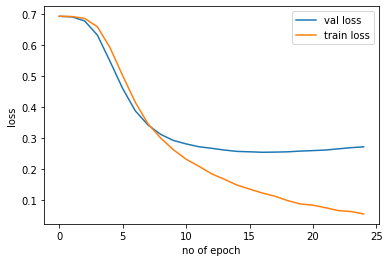

In [ ]:
# plotting the loss for the trained model
loss_plt(model_history)

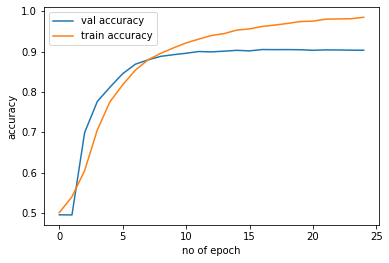

In [ ]:
# plotting the accuracy for the trained model
acc_plt(model_history)